#Polymarket and Stock Correlation

https://colab.research.google.com/drive/1TyDWXxCfmAZbBB3OzhtrhSdzbyD1c6fG?usp=sharing

# --- 1. Define Project ---
##Project Goal: Analyze if Polymarket prediction market data can help forecast short-term stock market movements.

##Problem Type: Supervised Learning - Regression (or Binary Classification)
##Data Sources: Polymarket event market data, public stock market data (e.g., SPY from yfinance)
##Output: Next-day or next-3-day price change or direction of equity index/asset


#POLYMARKET DATA

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# --- 3. Load and Visualize Polymarket Data ---
# Load CSV
pm_df = pd.read_csv("/content/FedRateCut.csv")
pm_df_info = pm_df.info()
pm_df_head = pm_df.head()
print(pm_df_info, pm_df_head) # features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date (UTC)       118 non-null    object 
 1   Timestamp (UTC)  118 non-null    int64  
 2   Price            118 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.9+ KB
None          Date (UTC)  Timestamp (UTC)  Price
0  03-06-2025 00:00       1741219205  0.925
1  03-07-2025 00:00       1741305605  0.915
2  03-08-2025 00:00       1741392005  0.925
3  03-09-2025 00:00       1741478405  0.915
4  03-10-2025 00:00       1741564804  0.915


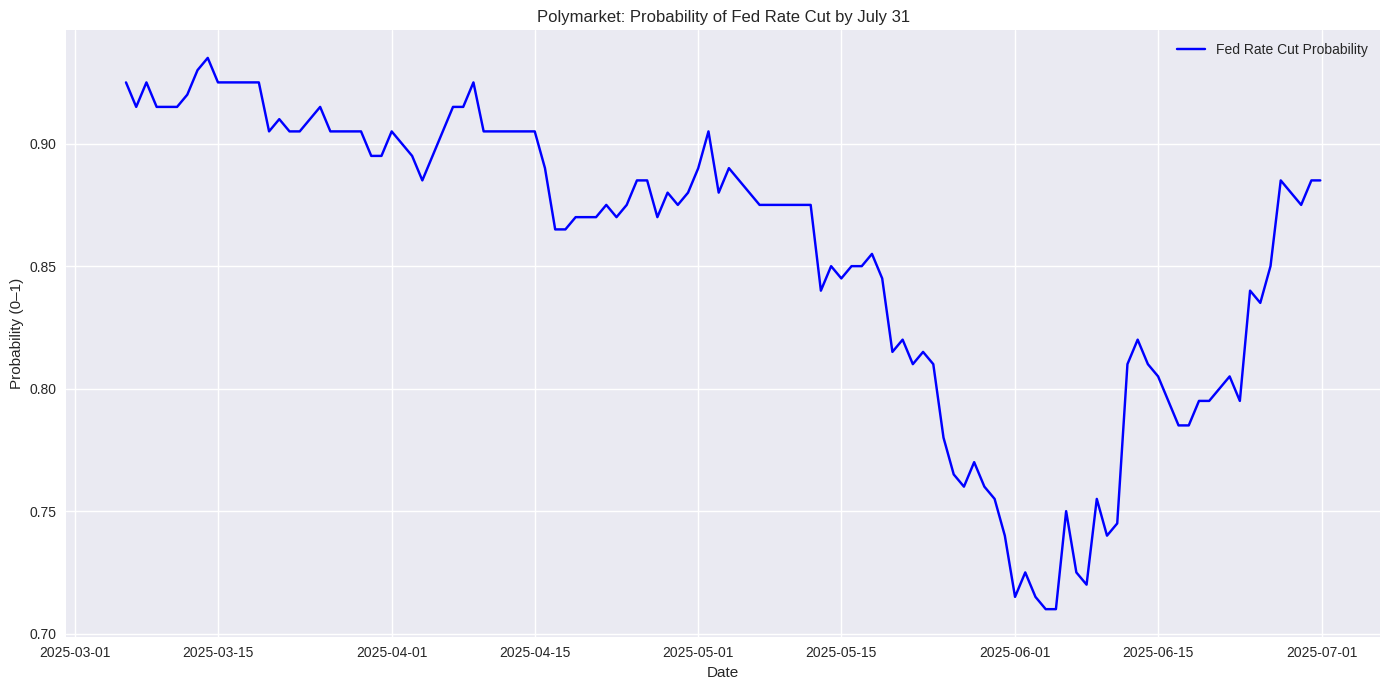

In [18]:
# Convert date column and set as index
pm_df['Date'] = pd.to_datetime(pm_df['Date (UTC)'])
pm_df.set_index('Date', inplace=True)

# Plot the single price series
plt.figure(figsize=(14, 7))
plt.plot(pm_df.index, pm_df['Price'], label='Fed Rate Cut Probability', color='blue')

# Formatting
plt.title("Polymarket: Probability of Fed Rate Cut by July 31")
plt.xlabel("Date")
plt.ylabel("Probability (0–1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#NASDAQ DATA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        123 non-null    object 
 1   Close/Last  123 non-null    float64
 2   Volume      123 non-null    int64  
 3   Open        123 non-null    float64
 4   High        123 non-null    float64
 5   Low         123 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 5.9+ KB


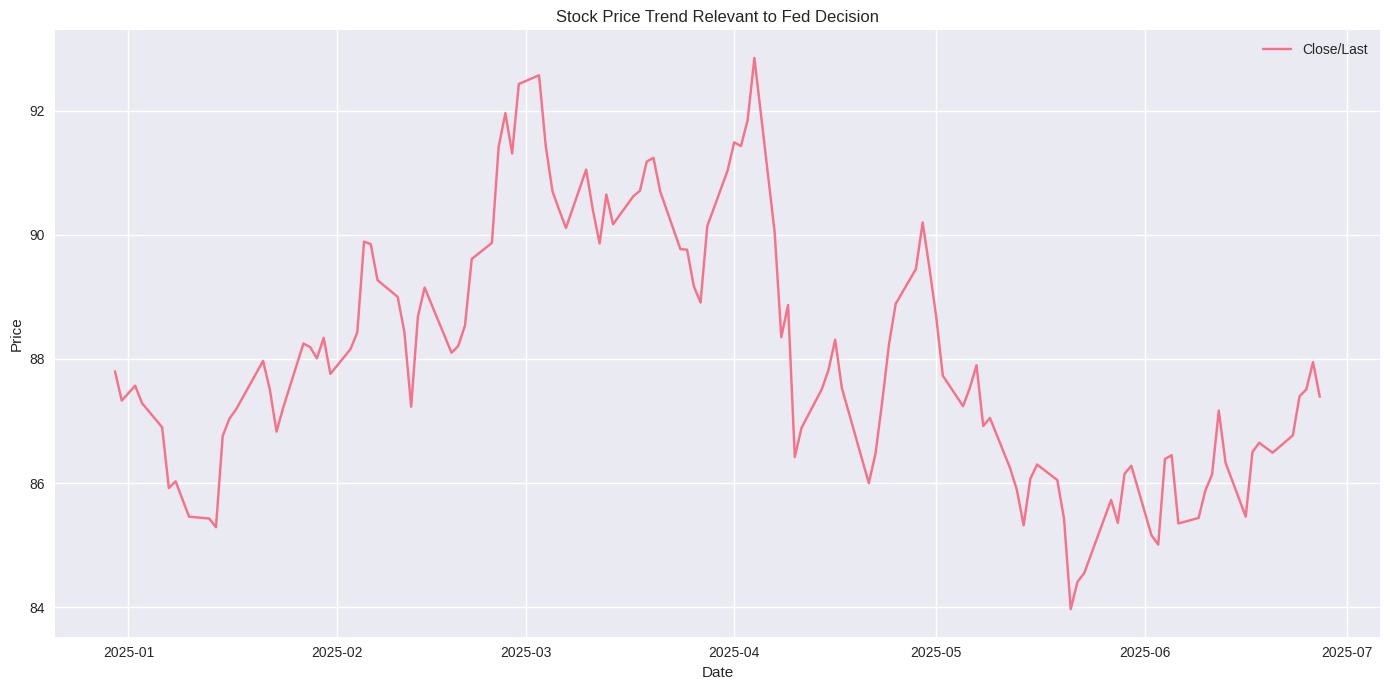

(None,
          Date  Close/Last    Volume   Open     High     Low
 0  06/27/2025       87.39  74993500  87.57  88.1600  87.235
 1  06/26/2025       87.95  30467520  87.59  87.9500  87.200
 2  06/25/2025       87.51  26345290  87.11  87.5100  86.800
 3  06/24/2025       87.40  32959110  86.47  87.5900  86.425
 4  06/23/2025       86.77  36851820  86.93  87.4407  86.770)

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the new CSV file
fed_stock_df = pd.read_csv("/content/TLT.csv")

# Display structure and first few rows
fed_stock_info = fed_stock_df.info()
fed_stock_head = fed_stock_df.head()

# Convert 'Date' column to datetime and set as index
fed_stock_df['Date'] = pd.to_datetime(fed_stock_df['Date'])
fed_stock_df.set_index('Date', inplace=True)

# Plot all columns over time (excluding volume if present)
plot_cols = [col for col in fed_stock_df.columns if col.lower() not in ['volume', 'open', 'high', 'low']]

plt.figure(figsize=(14, 7))
for col in plot_cols:
    plt.plot(fed_stock_df.index, fed_stock_df[col], label=col)

plt.title("Stock Price Trend Relevant to Fed Decision")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

fed_stock_info, fed_stock_head


# matching dates

Import Libraries

In [20]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

Load and Prepare Polymarket Data

In [21]:
# --- Load and prep Polymarket data ---
pm_df = pd.read_csv("/content/FedRateCut.csv")
pm_df['Date'] = pd.to_datetime(pm_df['Date (UTC)'])
pm_df.set_index('Date', inplace=True)
pm_df = pm_df[['Price']].sort_index()

Download and Prepare TLT Data

In [22]:
# --- Load and prep TLT (or any stock/ETF) ---
tlt_df = yf.download("TLT",
                     start=pm_df.index.min(),
                     end=pm_df.index.max(),
                     auto_adjust=True,
                     progress=False)

# Flatten MultiIndex if necessary
if isinstance(tlt_df.columns, pd.MultiIndex):
    tlt_df.columns = tlt_df.columns.get_level_values(0)

# Select and rename Close column
tlt_df = tlt_df[['Close']].rename(columns={'Close': 'TLT_Close'})

# Calculate next-day returns
tlt_df['TLT_Return'] = tlt_df['TLT_Close'].pct_change().shift(-1)
tlt_df.dropna(inplace=True)

Align Dates and Merge Datasets

In [23]:
# --- Align Polymarket to Stock Market Dates ---
pm_aligned = pm_df.reindex(tlt_df.index, method='ffill')

# Reset indices
tlt_reset = tlt_df.reset_index()
pm_reset = pm_aligned.reset_index()

# Rename for merging
tlt_reset.rename(columns={'Date': 'MergeDate'}, inplace=True)
pm_reset.rename(columns={'Date': 'MergeDate'}, inplace=True)

# Merge datasets
merged_df = pd.merge(tlt_reset, pm_reset, on='MergeDate', how='inner')
merged_df.set_index('MergeDate', inplace=True)


Preview Merged Data

In [24]:
print("Merged DataFrame Info:")
print(merged_df.info())
print("\nFirst 5 rows:")
print(merged_df.head())
print("\nLast 5 rows:")
print(merged_df.tail())

Merged DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79 entries, 2025-03-06 to 2025-06-27
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TLT_Close   79 non-null     float64
 1   TLT_Return  79 non-null     float64
 2   Price       79 non-null     float64
dtypes: float64(3)
memory usage: 2.5 KB
None

First 5 rows:
            TLT_Close  TLT_Return  Price
MergeDate                               
2025-03-06  89.080849   -0.003208  0.925
2025-03-07  88.795082    0.010432  0.915
2025-03-10  89.721375   -0.007139  0.915
2025-03-11  89.080849   -0.005973  0.915
2025-03-12  88.548737    0.008791  0.920

Last 5 rows:
            TLT_Close  TLT_Return  Price
MergeDate                               
2025-06-23  86.447495    0.007261  0.795
2025-06-24  87.075165    0.001259  0.840
2025-06-25  87.184753    0.005028  0.835
2025-06-26  87.623116   -0.006367  0.850
2025-06-27  87.065193    0.009841  0.885


Correlation Calculation

In [25]:
correlation = merged_df['Price'].corr(merged_df['TLT_Close'])
print(f"\nCorrelation between Fed Cut Probability and TLT Price: {correlation:.4f}")



Correlation between Fed Cut Probability and TLT Price: 0.6741


Time Series Plot

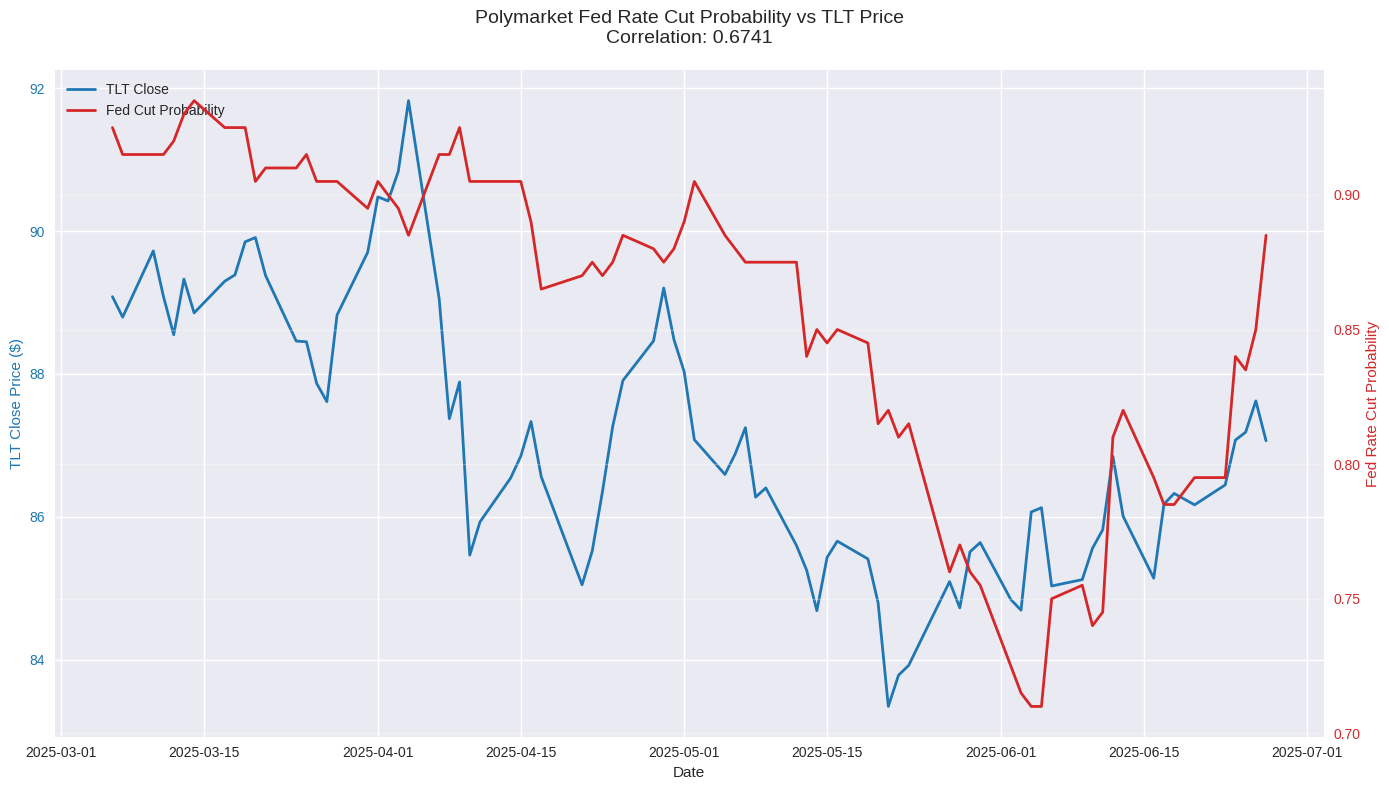

In [26]:
fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.set_xlabel('Date')
ax1.set_ylabel('TLT Close Price ($)', color='tab:blue')
ax1.plot(merged_df.index, merged_df['TLT_Close'],
         color='tab:blue', label='TLT Close', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Fed Rate Cut Probability', color='tab:red')
ax2.plot(merged_df.index, merged_df['Price'],
         color='tab:red', label='Fed Cut Probability', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Polymarket Fed Rate Cut Probability vs TLT Price\n" +
          f"Correlation: {correlation:.4f}", fontsize=14, pad=20)
fig.tight_layout()
plt.grid(True, alpha=0.3)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()


Scatter Plot with Trend Line

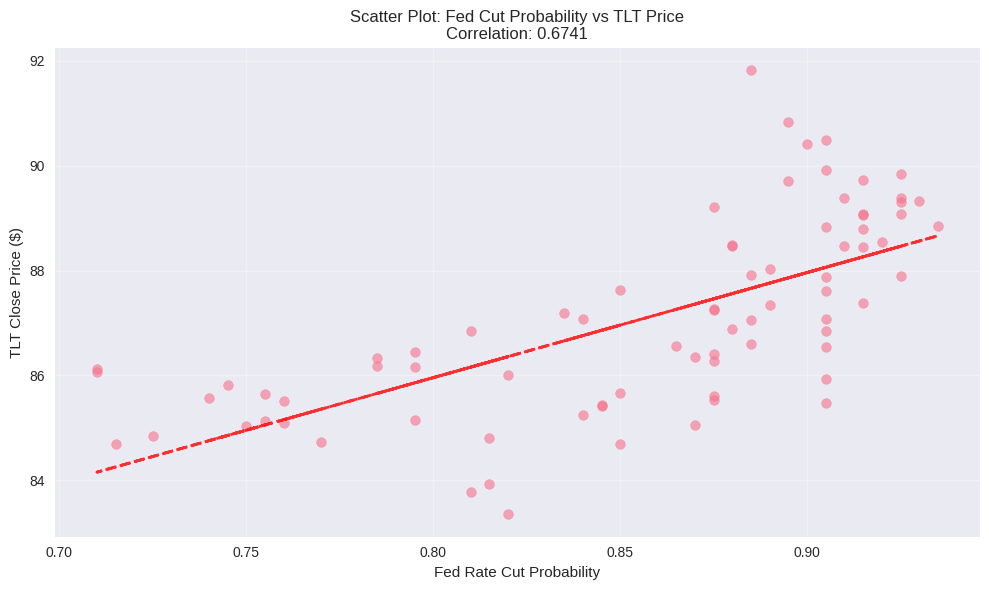

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Price'], merged_df['TLT_Close'], alpha=0.6, s=50)
plt.xlabel('Fed Rate Cut Probability')
plt.ylabel('TLT Close Price ($)')
plt.title(f'Scatter Plot: Fed Cut Probability vs TLT Price\nCorrelation: {correlation:.4f}')
plt.grid(True, alpha=0.3)

# Trend line
z = np.polyfit(merged_df['Price'], merged_df['TLT_Close'], 1)
p = np.poly1d(z)
plt.plot(merged_df['Price'], p(merged_df['Price']), "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()


Summary Statistics

In [28]:
print("\n=== SUMMARY STATISTICS ===")
print(f"Date range: {merged_df.index.min().strftime('%Y-%m-%d')} to {merged_df.index.max().strftime('%Y-%m-%d')}")
print(f"Number of observations: {len(merged_df)}")

print(f"\nFed Rate Cut Probability:")
print(f"  Mean: {merged_df['Price'].mean():.3f}")
print(f"  Std:  {merged_df['Price'].std():.3f}")
print(f"  Min:  {merged_df['Price'].min():.3f}")
print(f"  Max:  {merged_df['Price'].max():.3f}")

print(f"\nTLT Close Price:")
print(f"  Mean: ${merged_df['TLT_Close'].mean():.2f}")
print(f"  Std:  ${merged_df['TLT_Close'].std():.2f}")
print(f"  Min:  ${merged_df['TLT_Close'].min():.2f}")
print(f"  Max:  ${merged_df['TLT_Close'].max():.2f}")

print(f"\nCorrelation: {correlation:.4f}")
if abs(correlation) > 0.7:
    strength = "Strong"
elif abs(correlation) > 0.4:
    strength = "Moderate"
elif abs(correlation) > 0.2:
    strength = "Weak"
else:
    strength = "Very weak"

direction = "positive" if correlation > 0 else "negative"
print(f"Relationship: {strength} {direction} correlation")



=== SUMMARY STATISTICS ===
Date range: 2025-03-06 to 2025-06-27
Number of observations: 79

Fed Rate Cut Probability:
  Mean: 0.856
  Std:  0.062
  Min:  0.710
  Max:  0.935

TLT Close Price:
  Mean: $87.08
  Std:  $1.85
  Min:  $83.35
  Max:  $91.82

Correlation: 0.6741
Relationship: Moderate positive correlation


#prediction

1. DATA LOADING AND PREPARATION


In [29]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                           accuracy_score, classification_report, confusion_matrix,
                           precision_recall_fscore_support)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Define the function here so it's available when called
def calculate_rsi(prices, window=14):
    """Calculate Relative Strength Index"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))


print(" TLT Price/Return Prediction from Polymarket Data")
print("=" * 60)

# --- 1. DATA LOADING AND PREPARATION ---
print("\n Loading and preparing data...")

# Load Polymarket data
pm_df = pd.read_csv("/content/FedRateCut.csv")
pm_df['Date'] = pd.to_datetime(pm_df['Date (UTC)'])
pm_df.set_index('Date', inplace=True)
pm_df = pm_df[['Price']].sort_index()

# Load TLT data
tlt_df = yf.download("TLT",
                     start=pm_df.index.min(),
                     end=pm_df.index.max(),
                     auto_adjust=True,
                     progress=False)

# Handle MultiIndex if present
if isinstance(tlt_df.columns, pd.MultiIndex):
    tlt_df.columns = tlt_df.columns.get_level_values(0)

# Calculate various target variables
tlt_df['TLT_Close'] = tlt_df['Close']
tlt_df['TLT_Return_1d'] = tlt_df['Close'].pct_change().shift(-1)  # Next day return
tlt_df['TLT_Return_3d'] = tlt_df['Close'].pct_change(3).shift(-3)  # Next 3-day return
tlt_df['Price_Change_1d'] = tlt_df['Close'].diff().shift(-1)  # Next day price change
tlt_df['Direction_1d'] = (tlt_df['TLT_Return_1d'] > 0).astype(int)  # Binary direction

# Align and merge data
pm_aligned = pm_df.reindex(tlt_df.index, method='ffill')
merged_df = pd.concat([tlt_df, pm_aligned], axis=1, join='inner')
merged_df.dropna(inplace=True)

print(f"Data shape: {merged_df.shape}")
print(f"Date range: {merged_df.index.min()} to {merged_df.index.max()}")

 TLT Price/Return Prediction from Polymarket Data

 Loading and preparing data...
Data shape: (77, 11)
Date range: 2025-03-06 00:00:00 to 2025-06-25 00:00:00


2. FEATURE ENGINEERING


In [30]:
print("\n🔧 Creating features...")

# Polymarket features
merged_df['PM_Price_MA3'] = merged_df['Price'].rolling(3).mean()
merged_df['PM_Price_MA7'] = merged_df['Price'].rolling(7).mean()
merged_df['PM_Price_Change'] = merged_df['Price'].diff()
merged_df['PM_Price_Change_3d'] = merged_df['Price'].diff(3)
merged_df['PM_Volatility'] = merged_df['Price'].rolling(5).std()
merged_df['PM_Price_Lag1'] = merged_df['Price'].shift(1)
merged_df['PM_Price_Lag2'] = merged_df['Price'].shift(2)

# Technical indicators for TLT
merged_df['TLT_MA5'] = merged_df['TLT_Close'].rolling(5).mean()
merged_df['TLT_MA10'] = merged_df['TLT_Close'].rolling(10).mean()
merged_df['TLT_Volatility'] = merged_df['TLT_Close'].rolling(5).std()

# Recalculate RSI properly
merged_df['TLT_RSI'] = calculate_rsi(merged_df['TLT_Close'])

# Drop rows with NaN values
merged_df.dropna(inplace=True)

# Define feature columns
feature_cols = ['Price', 'PM_Price_MA3', 'PM_Price_MA7', 'PM_Price_Change',
               'PM_Price_Change_3d', 'PM_Volatility', 'PM_Price_Lag1', 'PM_Price_Lag2',
               'TLT_MA5', 'TLT_MA10', 'TLT_Volatility', 'TLT_RSI']

print(f"Features created: {len(feature_cols)}")
print(f"Final dataset shape: {merged_df.shape}")


🔧 Creating features...
Features created: 12
Final dataset shape: (64, 22)


3. PREPARE DATASETS FOR MODELING


In [31]:
print("\n Setting up train/test splits...")

# Use TimeSeriesSplit for proper time series validation
X = merged_df[feature_cols]
y_price = merged_df['TLT_Close']
y_return_1d = merged_df['TLT_Return_1d']
y_return_3d = merged_df['TLT_Return_3d']
y_direction = merged_df['Direction_1d']

# Standard train-test split (80-20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_price_train, y_price_test = y_price[:split_idx], y_price[split_idx:]
y_return_1d_train, y_return_1d_test = y_return_1d[:split_idx], y_return_1d[split_idx:]
y_return_3d_train, y_return_3d_test = y_return_3d[:split_idx], y_return_3d[split_idx:]
y_direction_train, y_direction_test = y_direction[:split_idx], y_direction[split_idx:]

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")



 Setting up train/test splits...
Training set: (51, 12)
Test set: (13, 12)


4. REGRESSION MODELS


In [32]:
# --- 4. REGRESSION MODELS ---
print("\n Training Regression Models...")

# Scale features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define regression models
reg_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0, gamma='scale')
}

# Store results
reg_results = {}

# Train and evaluate regression models
for name, model in reg_models.items():
    print(f"\n--- {name} ---")

    # Choose scaled or unscaled features
    if name == 'SVR' or name == 'Linear Regression':
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test

    results = {}

    # 1-Day Return Prediction
    model.fit(X_tr, y_return_1d_train)
    y_pred_1d = model.predict(X_te)

    results['1d_return'] = {
        'r2': r2_score(y_return_1d_test, y_pred_1d),
        'rmse': np.sqrt(mean_squared_error(y_return_1d_test, y_pred_1d)),
        'mae': mean_absolute_error(y_return_1d_test, y_pred_1d),
        'predictions': y_pred_1d
    }

    # 3-Day Return Prediction
    model.fit(X_tr, y_return_3d_train)
    y_pred_3d = model.predict(X_te)

    results['3d_return'] = {
        'r2': r2_score(y_return_3d_test, y_pred_3d),
        'rmse': np.sqrt(mean_squared_error(y_return_3d_test, y_pred_3d)),
        'mae': mean_absolute_error(y_return_3d_test, y_pred_3d),
        'predictions': y_pred_3d
    }

    # Price Prediction
    model.fit(X_tr, y_price_train)
    y_pred_price = model.predict(X_te)

    results['price'] = {
        'r2': r2_score(y_price_test, y_pred_price),
        'rmse': np.sqrt(mean_squared_error(y_price_test, y_pred_price)),
        'mae': mean_absolute_error(y_price_test, y_pred_price),
        'predictions': y_pred_price
    }

    reg_results[name] = results

    # Print metrics
    print(f"1-Day Return - R²: {results['1d_return']['r2']:.4f}, RMSE: {results['1d_return']['rmse']:.6f}")
    print(f"3-Day Return - R²: {results['3d_return']['r2']:.4f}, RMSE: {results['3d_return']['rmse']:.6f}")
    print(f"Price - R²: {results['price']['r2']:.4f}, RMSE: {results['price']['rmse']:.4f}")


 Training Regression Models...

--- Linear Regression ---
1-Day Return - R²: -15.9153, RMSE: 0.026705
3-Day Return - R²: -65.9287, RMSE: 0.063615
Price - R²: -10.5749, RMSE: 2.3581

--- Random Forest ---
1-Day Return - R²: -1.8117, RMSE: 0.010888
3-Day Return - R²: -3.5086, RMSE: 0.016511
Price - R²: -0.0991, RMSE: 0.7266

--- SVR ---
1-Day Return - R²: -2.0486, RMSE: 0.011337
3-Day Return - R²: -2.0974, RMSE: 0.013685
Price - R²: -0.2844, RMSE: 0.7855
